In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tqdm import tqdm
import re
import scipy
import tensorflow
from tensorflow.keras.layers import Input,Flatten, Embedding, Reshape, Multiply, Dropout, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, GRU, LSTM
from tensorflow.keras.layers import Dot, TimeDistributed, BatchNormalization, Add, multiply
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
#import keras.backend as K
from sklearn.utils import shuffle
import seaborn as sns
import math
import shap

In [2]:
PATH = "../data/mind_small/"
news = pd.read_csv(PATH + "news.tsv",header=None, sep="\t")
behaviors = pd.read_csv(PATH + "behaviors.tsv", header=None, sep="\t")
news.columns = ["news_id", "category", "sub_category", "title", "abstract", "url", "title_entities", "abstract_entities"]
behaviors.columns = ["idx", "user_id", "time", "history", "impressions"]
behaviors = behaviors.drop_duplicates(["user_id", "history"]) 
behaviors.dropna(subset=["user_id", "history"], inplace=True)

In [7]:
sessions = {}
for idx, row in behaviors.iterrows():
    sessions[row["user_id"]] = row["history"].split(" ")

users = []
clicks = []
for k, v in sessions.items():
    for elem in v:
        users.append(k)
        clicks.append(elem)

tuples = list(zip(users, clicks))
interactions = pd.DataFrame(tuples, columns=["user", "news_id"])

In [8]:
interactions = interactions[:40000]

In [9]:
merged = interactions.merge(news, on=["news_id"])

In [10]:
print(len(merged))
merged = merged.drop_duplicates()
print(len(merged))

40000
39231


# 1. Preprocessing

In [11]:
# remove users which have fewer than 5 interacations
print("Len before removal: ",len(merged))
_keys = merged["user"].value_counts()[merged["user"].value_counts() > 5].keys()
merged = merged[merged["user"].isin(_keys)]
print("Len after removal: ",len(merged))


user_enc = LabelEncoder()
article_enc = LabelEncoder()
merged["user_id"] = user_enc.fit_transform(merged["user"].values)
merged["article_id"] = article_enc.fit_transform(merged["news_id"].values)

Len before removal:  39231
Len after removal:  38641


In [12]:
import nltk
from nltk.corpus import stopwords
# Helper functions
def _removeNonAscii(s):
    return "".join(i for i in s if  ord(i)<128)

def make_lower_case(text):
    return text.lower()

def remove_stop_words(text):
    text = text.split()
    stops = set(stopwords.words("english"))
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def remove_punctuation(text):
    text = re.sub(r'[^\w\s]', '', text)
    return text

def text_to_list(text):
    text = text.split(" ")
    return text

In [13]:
def clean_title(df):
    df["title_cleaned"] = df.title.apply(func = make_lower_case)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_stop_words)
    df["title_cleaned"] = df.title_cleaned.apply(func = remove_punctuation)
    return df
def hyphen_to_underline(category):
    """
    Convert hyphen to underline for the subcategories. So that Tfidf works correctly
    """
    return category.replace("-","_")
merged = clean_title(merged)
merged["subcategory_cleaned"] = merged["sub_category"].apply(func = hyphen_to_underline)

In [14]:
merged.head(1)

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities,user_id,article_id,title_cleaned,subcategory_cleaned
0,U13740,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata...",56,7667,wheel fortune guest delivers hilarious rails i...,tvnews


In [15]:
category_enc = LabelEncoder()
subcategory_enc = LabelEncoder()
merged["subcategory_int"] = subcategory_enc.fit_transform(merged["subcategory_cleaned"].values)
merged["category_int"] = subcategory_enc.fit_transform(merged["category"].values)

In [16]:
print(merged["subcategory_int"].nunique() / merged["article_id"].nunique())

0.019858156028368795


In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAXLEN=10

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(merged["title_cleaned"].values)
temp = tokenizer.texts_to_sequences(merged["title_cleaned"].values)
temp = pad_sequences(temp, padding="post", maxlen=MAXLEN)
merged["title_tokenized"] = temp.tolist()


In [17]:
import collections
from collections import Counter

In [18]:
users = merged["user_id"].unique()
userid_to_profile = collections.defaultdict(list)
for user_id in tqdm(users):
    user_subcat = merged[merged["user_id"] == user_id]["subcategory_int"].values.tolist()
    counter = Counter(user_subcat)
    s = sorted(user_subcat, key=lambda x: (counter[x], x), reverse=True)
    final_subcategories = []
    for elem in s:
        if elem not in final_subcategories:
            final_subcategories.append(elem)
    while len(final_subcategories) < 6:
        final_subcategories.append(0)
    userid_to_profile[user_id] = final_subcategories[:6]

100%|██████████| 1026/1026 [00:00<00:00, 1400.97it/s]


In [19]:
profile_df = pd.DataFrame.from_dict(userid_to_profile, orient="index")
profile_df["user_id"] = profile_df.index


In [20]:
merged = merged.merge(profile_df, on="user_id")

In [21]:
merged = merged.rename(columns={"0": "p0","1": "p1","2": "p2","3": "p3","4": "p4","5": "p5",})

In [22]:
userid_to_profile[0]

[76, 141, 147, 27, 25, 10]

In [23]:
article_id_to_category_int = merged[["article_id", "category_int"]].set_index("article_id").to_dict()
article_id_to_category_int = article_id_to_category_int["category_int"]

article_id_to_subcategory_int = merged[["article_id", "subcategory_int"]].set_index("article_id").to_dict()
article_id_to_subcategory_int = article_id_to_subcategory_int["subcategory_int"]

In [24]:
merged.head(1)

,user,news_id,category,sub_category,title,abstract,url,title_entities,abstract_entities,user_id,...,title_cleaned,subcategory_cleaned,subcategory_int,category_int,0,1,2,3,4,5
0,U13740,N55189,tv,tvnews,"'Wheel Of Fortune' Guest Delivers Hilarious, O...","We'd like to solve the puzzle, Pat: Blair Davi...",https://assets.msn.com/labs/mind/AAIORni.html,[],"[{""Label"": ""Pat Sajak"", ""Type"": ""P"", ""Wikidata...",56,...,wheel fortune guest delivers hilarious rails i...,tvnews,182,11,182,141,135,121,92,74


# 2. Train test split

In [25]:
def train_test_split(df, user_id, article_id, have_timestamp, timestamp):
    """
    params: 
        col_1: user_id
        col_2: article_id
    """
    df_test = df
    if have_timestamp: # if df have timestamp; take last interacted article into test set
        df_test = df_test.sort_values(timestamp).groupby(user_id).tail(1)
    else:
        df_test = df_test.sort_values(user_id).groupby(user_id).tail(1)
    df_train = df.drop(index=df_test.index)
    
    assert df_test.shape[0] + df_train.shape[0] == df.shape[0]
    
    return df_train, df_test
df_train_true, df_test_true = train_test_split(merged, "user_id", "article_id", False, 0)

In [26]:
def get_userid_to_article_history(df):
    userid_to_article_history = {}
    for user_id in tqdm(df["user_id"].unique()):
        click_history = df[df["user_id"] == user_id]["article_id"].values
        if len(click_history) < 30:
            while len(click_history) < 30:
                click_history = np.append(click_history, 0)
        if len(click_history) > 30:
            click_history = click_history[:30]
        userid_to_article_history[user_id] = click_history
    return userid_to_article_history
userid_to_article_history = get_userid_to_article_history(df_train_true)

100%|██████████| 1026/1026 [00:00<00:00, 1515.17it/s]


In [27]:
all_article_ids = merged["article_id"].unique()

def negative_sampling(train_df, all_article_ids, user_id, article_id):
    """
    Negative sample training instance; for each positive instance, add 4 negative articles
    
    Return user_ids, news_ids, category_1, category_2, authors_onehotencoded, titles
    """
    
    user_ids, user_click_history, articles, article_category, article_sub_category, labels = [], [], [], [], [], []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    user_item_set = set(zip(train_df[user_id], 
                            train_df[article_id]))
    num_negatives = 4

    for (u, i) in tqdm(user_item_set):
        user_ids.append(u)
        user_click_history.append(userid_to_article_history[u])
        profile = np.array(userid_to_profile[u])
        p0.append(profile[0])
        p1.append(profile[1])
        p2.append(profile[2])
        p3.append(profile[3])
        p4.append(profile[4])
        p5.append(profile[5])
        article_category.append(article_id_to_category_int[i])
        article_sub_category.append(article_id_to_subcategory_int[i])
        
        articles.append(i)
        labels.append(1)
        for _ in range(num_negatives):
            negative_item = np.random.choice(all_article_ids)
            while (u, negative_item) in user_item_set:
                negative_item = np.random.choice(all_article_ids)
            user_ids.append(u)
            user_click_history.append(userid_to_article_history[u])
            p0.append(profile[0])
            p1.append(profile[1])
            p2.append(profile[2])
            p3.append(profile[3])
            p4.append(profile[4])
            p5.append(profile[5])
            
            article_category.append(article_id_to_category_int[negative_item])
            article_sub_category.append(article_id_to_subcategory_int[negative_item])
            
            articles.append(negative_item)
            labels.append(0)
    
    user_ids, user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels = shuffle(user_ids,user_click_history, p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels, random_state=0)

    return pd.DataFrame(list(zip(user_ids,user_click_history,p0, p1, p2, p3, p4, p5, articles,article_category,article_sub_category, labels)), columns=["user_id","user_history","p0", "p1", "p2", "p3", "p4", "p5", "article_id","article_category","article_sub_category", "labels"])



df_train = negative_sampling(df_train_true, all_article_ids, "user_id", "article_id")

100%|██████████| 37615/37615 [00:01<00:00, 24167.27it/s]


In [28]:
def fix_dftrain(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_train = fix_dftrain(df_train, "user_history", 30, 0)
df_train.drop(columns=["user_history"], inplace=True)
df_train.head()

100%|██████████| 30/30 [00:03<00:00,  8.21it/s]


,user_id,p0,p1,p2,p3,p4,p5,article_id,article_category,article_sub_category,...,user_history_20,user_history_21,user_history_22,user_history_23,user_history_24,user_history_25,user_history_26,user_history_27,user_history_28,user_history_29
0,775,176,146,141,128,124,192,3873,4,192,...,6639,8848,276,4562,0,0,0,0,0,0
1,500,159,141,76,186,163,147,5129,10,176,...,0,0,0,0,0,0,0,0,0,0
2,281,76,146,141,74,25,27,7495,8,141,...,6104,5316,8658,8608,5532,2776,1438,2807,4767,8753
3,660,146,92,141,115,147,135,3104,8,146,...,1796,4771,7015,3832,3239,2410,6207,838,3874,4652
4,354,41,158,110,147,146,60,6194,4,192,...,1900,3553,7687,4638,1008,454,9618,1109,3431,7653


In [29]:
# For each user; for each item the user has interacted with in the test set;
    # Sample 99 items the user has not interacted with in the past and add the one test item  
    
def negative_sample_testset(ordiginal_df, df_test, all_article_ids, user_id, article_id):
    test_user_item_set = set(zip(df_test[user_id], df_test[article_id]))
    user_interacted_items = ordiginal_df.groupby(user_id)[article_id].apply(list).to_dict()
    users = []
    p0, p1, p2, p3, p4, p5, p6, p7, p8, p9 = [], [], [], [], [], [], [], [], [], []
    res_arr = []
    article_category, article_sub_category = [], []
    
    userid_to_true_item = {} # keep track of the real items
    for (u,i) in tqdm(test_user_item_set):
        interacted_items = user_interacted_items[u]
        not_interacted_items = set(all_article_ids) - set(interacted_items)
        selected_not_interacted = list(np.random.choice(list(not_interacted_items), 99))
        test_items = [i]+selected_not_interacted # NB! put [i] + ... first to reduce biased results
        temp = []
        profile = userid_to_profile[u]
        for j in range(len(test_items)):
            temp.append([u,
                         userid_to_article_history[u], 
                         profile[0],
                         profile[1],
                         profile[2],
                         profile[3],
                         profile[4],
                         profile[5], 
                         test_items[j], article_id_to_category_int[test_items[j]],
                        article_id_to_subcategory_int[test_items[j]]])
        #            user_click_history.append(userid_to_article_history[u])

        res_arr.append(temp)
        userid_to_true_item[u] = i 
    X_test = np.array(res_arr)
    X_test = X_test.reshape(-1, X_test.shape[-1])
    df_test = pd.DataFrame(X_test, columns=["user_id",
                                            "click_history", 
                                            "p0", 
                                            "p1", 
                                            "p2", 
                                            "p3", 
                                            "p4", 
                                            "p5",
                                            "article_id", 
                                            "category", 
                                            "sub_category"])
    return X_test, df_test, userid_to_true_item
X_test, df_test, userid_to_true_item = negative_sample_testset(merged, df_test_true, merged["article_id"].unique(), "user_id", "article_id")
    
    

100%|██████████| 1026/1026 [00:02<00:00, 379.94it/s]
Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [30]:
def fix_dftest(df, column, max_len, padding):
    i = 0
    for i in tqdm(range(max_len)):
        df[column + "_" + str(i)] = df[column].apply(lambda x: x[i] if i < len(x) else padding)
    #df.drop(column, axis=1, inplace=True)
    return df

df_test = fix_dftest(df_test, "click_history", 30, 0)
df_test.drop(columns=["click_history"], inplace=True)

100%|██████████| 30/30 [00:01<00:00, 18.93it/s]


In [31]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

In [44]:
def evaluate_one_rating(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg,hr_five,ndcg_five

def evalaute_model(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five = []
    ndcgs_five = []
    users = df_test["user_id"].unique()[:200]
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        
        ht, ndcg, ht_five, ndcg_five = evaluate_one_rating(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(ht_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs,hits_five,ndcgs_five

In [33]:
def write_accuracy_results(model_name, hit_ten, ndcg_ten, hit_five, ndcg_five):
    try:
        file = open("performance.txt", "a")
        s = model_name +": Hit@10 : "+ str(hit_ten)+", NDCG@10: "+ str(ndcg_ten)+", Hit@5:" + str(hit_five)+", ndcg@5 "+ str(ndcg_five) + "\n"
        file.write(s)
        file.close()
    except:
        print("error file wriite")

def write_category_results(model_name, hit_ten, ndcg_ten, hit_five, ndcg_five):
    try:
        file = open("category_performance.txt", "a")
    
        s = model_name +": Hit@10 : "+ str(hit_ten)+", NDCG@10: "+ str(ndcg_ten)+", Hit@5:" + str(hit_five)+", ndcg@5 "+ str(ndcg_five) + "\n"
        file.write(s)
        file.close()
    except:
        print("error file wriite")
    

# 4. Models

In [34]:
# Params
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique()) 
dims = 20
num_sub_categories = len(merged["subcategory_int"].unique())+1
num_categories = len(merged["category_int"].unique())+1

In [35]:
print(num_sub_categories)

197


In [37]:
#@tf.autograph.experimental.do_not_convert
def get_model(num_users, num_items, dims,num_categories,num_sub_categories, dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    # User emb
    click_history_emb = Embedding(output_dim=dims, input_dim=num_items+1, input_length=30, name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=dims, input_dim=num_sub_categories, input_length=6, name="mf_profile_emb")(user_profile_input)
    
    # Item emb
    item_emb = Embedding(output_dim=dims, input_dim=num_items+1, input_length=1, name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=dims, input_dim=num_categories, input_length=1, name="cat_emb")(item_category)
    subcategory_emb = Embedding(output_dim=dims, input_dim=num_sub_categories, input_length=1, name="subcat_emb")(item_subcategory)
    
    ### Wide
    #wide_history = Flatten()(click_history_emb)
    #wide_item = Flatten()(item_input)
    wide = Concatenate(axis=1)([click_history_emb, item_emb])
    wide = Flatten()(wide)
    y_wide = Dense(2)(wide)
    
    ### Deep
    deep_features = Concatenate(axis=1)([category_emb,subcategory_emb, profile_emb])
    x_deep = LSTM(40)(deep_features)
    
    print(x_deep.shape)
    print(y_wide.shape)
    
    final = Concatenate()([x_deep, y_wide])
    final = BatchNormalization(axis=1)(final)
   
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category, item_subcategory], outputs=y)
    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_final = get_model(num_users, num_items, dims, num_categories,num_sub_categories)

(None, 40)
(None, 2)


In [38]:
###### Training ########
user_history = df_train.iloc[:, 11:].values.astype("int64")
profile_input = df_train.iloc[:, 1:7].values.astype("int64")
item_input = df_train.iloc[:, 7].values.reshape((-1,1)).astype("int64")
labels = df_train.iloc[:, 10].values.reshape((-1,1)).astype("int64")
category_input = df_train.iloc[:, 8].values.reshape((-1,1)).astype("int64")
subcategory_input = df_train.iloc[:, 9].values.reshape((-1,1)).astype("int64")
print(user_history.shape,profile_input.shape, item_input.shape, labels.shape )

(188075, 30) (188075, 6) (188075, 1) (188075, 1)


In [39]:
all_user_ids = merged["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=10
for epoch in range(epochs):
    hist = model_final.fit([user_history, profile_input, item_input,category_input, subcategory_input ], labels, epochs=1,validation_split=0.1, shuffle=True, verbose=1)    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model( model_final, df_test[:10000], userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    #if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_ndcgs = temp_ndcgs
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)

5290/5290 [==============================] - 26s 5ms/step - loss: 0.3432 - accuracy: 0.8505 - val_loss: 0.3876 - val_accuracy: 0.8403


In [45]:
hits, ndcgs, hits_five, ndcgs_five = evalaute_model( model_final, df_test, userid_to_true_item)

  1%|          | 2/200 [00:00<00:12, 16.04it/s]

Evaluate model


100%|██████████| 200/200 [00:11<00:00, 17.17it/s]


In [47]:
print("Hit @ 10: {:.2f}".format(np.average(hits)))
print("ncdgs @ 10: {:.2f}".format(np.average(ndcgs)))
print("Hit @ 10: {:.2f}".format(np.average(hits_five)))
print("ncdgs @ 10: {:.2f}".format(np.average(ndcgs_five)))

Hit @ 10: 0.55
ncdgs @ 10: 0.36
Hit @ 10: 0.44
ncdgs @ 10: 0.32


In [ ]:
write_accuracy_results("main", best_hits, best_ndcgs, best_hits_five, best_ndcgs_five)

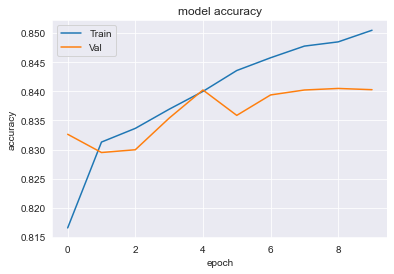

In [40]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("final_accuracy.pdf")
plt.show()


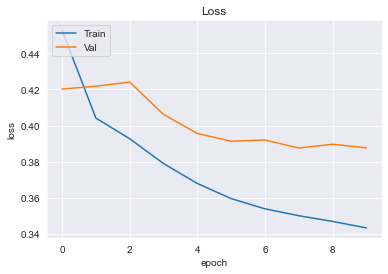

In [41]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("final_loss.pdf")
plt.show()

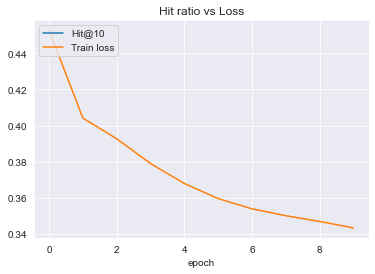

In [42]:
sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("final_hit_loss.pdf")
plt.show()

In [ ]:
def get_article_category(article_id):
    return merged[merged["article_id"] == article_id]["subcategory_cleaned"].values[0]
def get_userprofile_to_name(user_id, id_to_subcategory):
    """
    Return array of strings with category names
    """
    arr_profile = get_user_profile(df_train,user_id )
    return [id_to_subcategory[elem] for elem in arr_profile]
def get_user_profile(df, user_id):
    """
    Return the user profile given user_id
    """
    return df[df["user_id"] == user_id].iloc[0, 1:7].values
def get_article_content(article_id):
    article = merged[merged["article_id"] == article_id].head(1)
    title = article["title"].values[0]
    sub_category = article["sub_category"].values[0]
    return title, sub_category

def get_item_features(user_id):
    d = df_test[df_test["user_id"] == user_id]
    return d["category"].values.reshape(-1,1), d["sub_category"].values.reshape(-1,1)

def get_item_features_one_item(article_id):
    d = df_test[df_test["article_id"] == article_id]
    return np.array(d["category"].values[0]), np.array(d["sub_category"].values[0])

In [ ]:
def get_article_category(article_id, df):
    """
    Return the article's category
        type: int
    """
    return df[df["article_id"] == article_id]["category"].values[0]
def get_article_subcategory(article_id, df):
    """
    Return the article's category
        type: int
    """
    return df[df["article_id"] == article_id]["sub_category"].values[0]
def get_category_hit_ratio(user_profile, top_ten_categories):
    num_hits = 0
    for profile in user_profile:
        for category in top_ten_categories:
            if profile == category:
                num_hits+= 1
    
    return num_hits
def get_ndcgs_category(user_profile, top_ten_categories):
    for i in range(len(top_ten_categories)):
        item = top_ten_categories[i]
        for profile in user_profile:
            if item == profile:
                return math.log(2) / math.log(i+2)
    return 0

In [ ]:
def get_recommendations(user_id, df, model):
    
    ## Setup ###
    user_profile = get_user_profile(df, user_id)
    click_history = userid_to_article_history[user_id]
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    category, sub_category = get_item_features(user_id)
    user_ids = np.tile(np.array(user_id), display_items.shape[0]).reshape(-1,1).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    click_history = np.tile(click_history, display_items.shape[0]).reshape(-1, 30).astype("int64")

    ## Preds ###
    predictions = model.predict([click_history, user_profile, display_items, category, sub_category])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items



In [ ]:
def predict_all_users(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []

    counter = 0
    for user_id in tqdm(df["user_id"].unique()[:100]):
        top_ten_articles = get_recommendations(user_id, df, model)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = get_user_profile(df_test, user_id)

        num_hits = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        #print(num_hits)
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(num_hits)
        ndcgs_ten.append(ndcg_ten)
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        counter += 1
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten,category_hits_five,category_ndcg_five   = predict_all_users(df_test,model_final)

In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

In [ ]:
write_category_results("main", category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five)

In [ ]:
category_hits_ten

# 4.1 Arch 1

In [ ]:
def evaluate_one_rating_arc1(model, user_id, all_articles, true_item):
    ### Reshaping to make it on the right shape ###
    expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    predictions = model.predict([expanded_user_id, all_articles])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg, hr_five, ndcg_five

def evalaute_model_arc1(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        
        
        ht, ndcg, hr_five, ndcg_five = evaluate_one_rating_arc1(model, user_id, all_articles, true_item)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(hr_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs, hits_five, ndcgs_five

In [ ]:
# Params
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique()) 
dims = 20

In [ ]:
#@tf.autograph.experimental.do_not_convert
def get_model(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    
    user_emb = Embedding(output_dim=dims, input_dim=num_users, input_length=1, name="mf_user_emb")(user_input)
    item_emb = Embedding(output_dim=dims, input_dim=num_items, input_length=1, name="mf_item_emb")(item_input)
    
    user_vecs = Reshape([dims])(user_emb)
    item_vecs = Reshape([dims])(item_emb)
    
    y = Dot(1, normalize=False)([user_vecs, item_vecs])
    
    y = Dense(1, activation="sigmoid")(y)
    
    
    model = Model(inputs=[user_input, item_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="mse",
        metrics=["accuracy"],
    )
    return model

model_arc1 = get_model(num_users, num_items, dims)

In [ ]:
###### Training ########
user_input = df_train.iloc[:, 0].values.reshape((-1,1))
item_input = df_train.iloc[:, 7].values.reshape((-1,1))
labels = df_train.iloc[:, 10].values.reshape((-1,1))
print(user_input.shape, item_input.shape, labels.shape )

In [ ]:
all_user_ids = df_train["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))


train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0

epochs=6
for epoch in range(epochs):
    hist = model_arc1.fit([user_input, item_input], labels, epochs=1, shuffle=True, verbose=1, validation_split=0.1, batch_size=32)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model_arc1( model_arc1, df_test, userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    #if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_ndcgs = temp_ndcgs
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)
    
        
    
    

In [ ]:
hits, ndcgs, hits_five, ndcgs_five = evalaute_model_arc1( model_arc1, df_test, userid_to_true_item)

In [ ]:
print(np.average(hits))
print(np.average(ndcgs))
print(np.average(hits_five))
print(np.average(ndcgs_five))

In [ ]:
print(best_hits)
print(best_ndcgs)
print(best_hits_five)
print(best_ndcgs_five)

In [ ]:
write_accuracy_results("arc1", best_hits, best_ndcgs, best_hits_five, best_ndcgs_five)

In [ ]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc1_accuracy.pdf")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc1_loss.pdf")
plt.show()

In [ ]:
sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("arc1_hit_loss.pdf")
plt.show()

In [ ]:
def get_recommendations_arc1(user_id, df, model):
    
    ## Setup ###
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_ids = np.tile(np.array(user_id), display_items.shape[0]).reshape(-1,1).astype("int64")
    
    ## Preds ###
    predictions = model.predict([user_ids, display_items])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items

In [ ]:
def get_category_hits_ndcg_arc1(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []
    
    for user_id in tqdm(df["user_id"].unique()[:200]):
        top_ten_articles = get_recommendations_arc1(user_id, df, model)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = userid_to_profile[user_id]

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        
        
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five = get_category_hits_ndcg_arc1(df_test,model_arc1)

In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

In [ ]:
write_category_results("arc1", category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five)

# 4.1.1 Wide and Deep with features

In [39]:
def evaluate_one_rating_wide(model, user_id, user_profiles, all_articles,categories, sub_categories, true_item):
    ### Reshaping to make it on the right shape ###
    expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    predictions = model.predict([expanded_user_id, user_profiles, all_articles,categories, sub_categories])
    predicted_labels = np.squeeze(predictions)
    #print(predicted_labels)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg, hr_five, ndcg_five

def evalaute_model_wide(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()[:400]
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].to_numpy().astype(int) # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].to_numpy().astype(int)# get the user_profile
        
        categories = user_df.iloc[:, 8].to_numpy().astype(int)
        sub_categories = user_df.iloc[:, 9].to_numpy().astype(int)
        
        ht, ndcg, ht_five, ndcg_five = evaluate_one_rating_wide(model, user_id, user_profiles, all_articles,categories, sub_categories, true_item)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(ht_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs,hits_five,ndcgs_five

In [40]:
num_users = len(merged["user_id"].unique()) 
num_items = len(merged["article_id"].unique()) 
num_sub_categories = len(merged["subcategory_int"].unique())
num_categories = len(merged["category_int"].unique()) 
dims = 20

In [ ]:
def get_model_wide(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    #### Matrix factorization ####
    user_id_input = Input(shape=[1], name="user_id")
    item_id_input = Input(shape=[1], name="item_id")
    user_embedding = Embedding(input_dim=num_users, 
                               output_dim=dims, 
                               input_length=1, 
                               embeddings_initializer='he_normal', 
                               embeddings_regularizer=regularizers.l2(0.001),
                               name="user_embedding")(user_id_input)
    item_embedding = Embedding(input_dim=num_items, 
                               output_dim=dims, 
                               embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                               name="item_embedding")(item_id_input)
    
    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)
    mf_vec = Concatenate()([user_flatten, item_flatten])
    
    x_deep = Dense(128, activation="relu", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.001))(mf_vec)
    x_deep = Dropout(0.2)(x_deep)
    x_deep = Dense(64, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(x_deep)
    x_deep = Dropout(0.2)(x_deep)
    
    #### Wide part ####
    
    user_profile_input = Input(shape=(6,), name="user_profile")
    item_category_input = Input(shape=(1,), name="category_input")
    item_sub_category_input = Input(shape=(1,), name="subcategory_input")
    
    item_category_emb = Embedding(input_dim=num_categories, output_dim=dims, name="category_emd", embeddings_regularizer=regularizers.l2(0.001))(item_category_input)
    item_subcategory_emb = Embedding(input_dim=num_sub_categories, output_dim=dims,embeddings_regularizer=regularizers.l2(0.001), name="subcat_emb")(item_sub_category_input)
    user_profile_emb = Embedding(input_dim=num_sub_categories, output_dim=dims,embeddings_regularizer=regularizers.l2(0.001), name="profile_emb")(user_profile_input)

    item_category_flatten = Flatten()(item_category_emb)
    item_subcategory_flatten = Flatten()(item_subcategory_emb)
    user_profile_flatten = Flatten()(user_profile_emb)
    
    wide_features = Concatenate()([item_category_flatten, item_subcategory_flatten,  user_profile_flatten])
    
    x_wide = Dense(128, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(wide_features)
    x_wide = Dropout(0.5)(x_wide)
    x_wide = Dense(64, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(x_wide)
    x_wide = Dropout(0.5)(x_wide)
    
    final = Concatenate()([x_deep,x_wide])
    x = Dense(128, kernel_initializer='he_uniform',activation="relu")(final)
    x = Dropout(0.5)(x)
    y = Dense(1, activation="sigmoid")(x)
    
    
    model = Model(inputs=[user_id_input, user_profile_input, item_id_input, item_category_input, item_sub_category_input], outputs=y)
    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_wide = get_model_wide(num_users, num_items, dims)

In [ ]:
###### Training ########
user_input = df_train.iloc[:, 0].values.reshape((-1,1))
profile_input = df_train.iloc[:, 1:7].values
item_input = df_train.iloc[:, 7].values.reshape((-1,1))
labels = df_train.iloc[:, 10].values.reshape((-1))
category_input = df_train.iloc[:, 8].values.reshape((-1,1))
sub_category_input = df_train.iloc[:, 9].values.reshape((-1,1))
print(user_input.shape,profile_input.shape, item_input.shape,category_input.shape, sub_category_input.shape, labels.shape )

In [ ]:
all_user_ids = df_train["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0


epochs=4

for epoch in range(epochs):
    hist = model_wide.fit([user_input, profile_input, item_input,category_input,sub_category_input], labels,validation_split=0.1, epochs=1, shuffle=True, verbose=1, batch_size=32)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model_wide( model_wide, df_test, userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    #if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)
    #    best_ndcgs = temp_ndcgs

In [ ]:
hits, ndcgs, hits_five, ndcgs_five = evalaute_model_wide( model_wide, df_test, userid_to_true_item)
print(np.average(hits))
print(np.average(ndcgs))
print(np.average(hits_five))
print(np.average(ndcgs_five))

In [ ]:
print(best_hits)
print(best_ndcgs)
print(best_hits_five)
print(best_ndcgs_five)

In [ ]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("final_loss.pdf")
plt.show()

sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("final_hit_loss.pdf")
plt.show()

In [ ]:
def get_recommendations_wide(user_id, df, model):
    #user_history, profile_input, item_input
    ## Setup ###
    
    #user_input, profile_input, item_input, category_input,sub_category_input
    category, sub_category = get_item_features(user_id)
    user_profile = get_user_profile(df, user_id)
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    user_input = np.tile(user_id, display_items.shape[0]).reshape(-1, 1).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    ## Preds ###
    predictions = model.predict([user_input,user_profile,display_items, category,sub_category ])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items

In [ ]:
def get_category_hits_ndcg_wide(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []
    
    for user_id in tqdm(df["user_id"].unique()[:200]):
        top_ten_articles = get_recommendations_wide(user_id, df, model)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = userid_to_profile[user_id]

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        
        
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five = get_category_hits_ndcg_wide(df_test, model_wide)

In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

# 4.1.2 NeuMF with features

In [ ]:
def evaluate_one_rating_neumffeatures(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories, user_ids):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_ids,user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg,hr_five,ndcg_five

def evalaute_model_neumffeatures(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five = []
    ndcgs_five = []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        user_ids = np.tile(user_id, all_articles.shape[0]).reshape(-1,1).astype(int)
        
        ht, ndcg, ht_five, ndcg_five = evaluate_one_rating_neumffeatures(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,
                                       user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories, user_ids)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(ht_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs,hits_five,ndcgs_five

In [ ]:
num_users = len(merged["user_id"].unique())
num_items = len(merged["article_id"].unique())
dims = 20
def get_model_neumffeatures(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user_input")
    item_input = Input(shape=(1,), name="item")
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    
    mf_user_emb = Embedding(output_dim=dims, 
                            input_dim=num_users, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=dims, 
                            input_dim=num_items,
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            input_length=1, name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    
    
    
    
    # User emb
    mlp_click_history_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=num_items+1, input_length=30, name="mlp_user_emb")(user_history)
    mlp_profile_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=num_sub_categories, input_length=6, name="mlp_profile_emb")(user_profile_input)
    
    # Item emb
    mlp_item_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=num_items+1, input_length=1, name="mlp_item_emb")(item_input)
    mlp_category_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=num_categories, input_length=1, name="cat_emb")(item_category)
    mlp_subcategory_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=num_sub_categories, input_length=1, name="subcat_emb")(item_subcategory)
    
    ### Wide
    wide = Concatenate(axis=1)([mlp_click_history_emb,mlp_profile_emb,mlp_item_emb,mlp_category_emb,mlp_subcategory_emb ])
    mlp_vector = Flatten()(wide)
    
    # Matrix factorization
    mf_user_vecs = Flatten()(mf_user_emb)
    mf_item_vecs = Flatten()(mf_item_emb)
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    
    for num_nodes in dense_layers:
        l = Dense(num_nodes, activation="relu")
        mlp_vector = l(mlp_vector)
    
    y = Concatenate()([mf_vec, mlp_vector])
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input,user_history, user_profile_input, item_input,item_category, item_subcategory], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumffeatures = get_model_neumffeatures(num_users, num_items, dims)

In [ ]:
###### Training ########
user_ids = df_train.iloc[:,0].values.astype("int64")
user_history = df_train.iloc[:, 11:].values.astype("int64")
profile_input = df_train.iloc[:, 1:7].values.astype("int64")
item_input = df_train.iloc[:, 7].values.reshape((-1,1)).astype("int64")
labels = df_train.iloc[:, 10].values.reshape((-1,1)).astype("int64")
category_input = df_train.iloc[:, 8].values.reshape((-1,1)).astype("int64")
subcategory_input = df_train.iloc[:, 9].values.reshape((-1,1)).astype("int64")
print(user_history.shape,profile_input.shape, item_input.shape, labels.shape )

In [ ]:
all_user_ids = merged["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=3
for epoch in range(epochs):
    hist = model_neumffeatures.fit([user_ids, user_history, profile_input, item_input,category_input, subcategory_input ], labels, epochs=1,validation_split=0.1, shuffle=True, verbose=1, batch_size=32)    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model( model_final, df_test[:10000], userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    #if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_ndcgs = temp_ndcgs
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)

In [ ]:
hits, ndcgs, hits_five, ndcgs_five = evalaute_model_neumffeatures( model_neumffeatures, df_test, userid_to_true_item)
print(np.average(hits))
print(np.average(ndcgs))
print(np.average(hits_five))
print(np.average(ndcgs_five))

In [ ]:
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

In [ ]:
def get_recommendations_neumffeatures(user_id, df, model):
    #user_history, profile_input, item_input
    ## Setup ###
    #user_ids, user_history, profile_input, item_input,category_input, subcategory_input
    
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    click_history = userid_to_article_history[user_id]
    click_history = np.tile(click_history, display_items.shape[0]).reshape(-1, 30).astype("int64")
    category, sub_category = get_item_features(user_id)
    user_profile = get_user_profile(df, user_id)
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    user_id_input = np.tile(user_id, display_items.shape[0]).reshape(-1, 1).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    ## Preds ###
    predictions = model.predict([user_id_input,click_history, user_profile,display_items, category,sub_category ])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items

In [ ]:
def get_category_hits_ndcg_neumffeatures(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []
    
    for user_id in tqdm(df["user_id"].unique()[:200]):
        top_ten_articles = get_recommendations_neumffeatures(user_id, df, model)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = userid_to_profile[user_id]

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        
        
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five = get_category_hits_ndcg_neumffeatures(df_test, model_neumffeatures)

In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

# 4.2 Arch 2

In [ ]:
def evaluate_one_rating_arc2(model, user_id, user_profiles, all_articles,user_clicks, true_item):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    predictions = model.predict([user_clicks, user_profiles, all_articles])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg, hr_five,ndcg_five

def evalaute_model_arc2(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        
        ht, ndcg,hr_five,ndcg_five = evaluate_one_rating_arc2(model, user_id, user_profiles, all_articles,user_clicks, true_item)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(hr_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs,hits_five,ndcgs_five

In [ ]:
#@tf.autograph.experimental.do_not_convert
def get_model_arc2(num_users, num_items, dims, dense_layers=[128, 64, 32, 8]):
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    item_input = Input(shape=(1,), name="item")
    
    mf_user_emb = Embedding(output_dim=dims, input_dim=num_items, input_length=30, name="mf_user_emb")(user_history)
    mf_profile_emb = Embedding(output_dim=dims, input_dim=num_sub_categories, input_length=6, name="mf_profile_emb")(user_profile_input)
    mf_item_emb = Embedding(output_dim=dims, input_dim=num_items, input_length=1, name="mf_item_emb")(item_input)
    
    
    
    #profile_emb = GlobalAveragePooling1D()(mf_profile_emb)
    profile_vecs = Flatten()(mf_user_emb)
    user_vecs = Flatten()(mf_profile_emb)
    item_vecs = Reshape([dims])(mf_item_emb)
    
    user_vecs_complete = Concatenate(axis=1)([user_vecs, profile_vecs])
    input_vecs = Concatenate()([user_vecs_complete, item_vecs])
    x = Dense(128, activation="relu", name="dense_0")(input_vecs)
    x = Dropout(0.5)(x)
    y = Dense(1, activation="sigmoid", name="prediction")(x)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_arc2 = get_model_arc2(num_users, num_items, dims)

In [ ]:
###### Training ########
user_history = df_train.iloc[:, 11:].values.astype("int64")
profile_input = df_train.iloc[:, 1:7].values.astype("int64")
item_input = df_train.iloc[:, 7].values.reshape((-1,1)).astype("int64")
labels = df_train.iloc[:, 10].values.reshape((-1,1)).astype("int64")
print(user_history.shape,profile_input.shape, item_input.shape, labels.shape )

In [ ]:
all_user_ids = merged["user_id"].unique()

epochs=6

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

for epoch in range(epochs):
    hist = model_arc2.fit([user_history, profile_input, item_input], labels, epochs=1, shuffle=True, verbose=1, validation_split=0.1)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model_arc2( model_arc2, df_test, userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    #if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)
    #    best_ndcgs = temp_ndcgs
        

In [ ]:
write_accuracy_results("arc2", best_hits, best_ndcgs, best_hits_five, best_ndcgs_five)

In [ ]:
sns.set_style("darkgrid")
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc2_accuracy.pdf")
plt.show()


In [ ]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc2_loss.pdf")
plt.show()

In [ ]:
sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("arc2_hit_loss.pdf")
plt.show()

In [ ]:
def get_recommendations_arc2(user_id, df, model):
    #user_history, profile_input, item_input
    ## Setup ###
    
    click_history = userid_to_article_history[user_id]
    user_profile = get_user_profile(df, user_id)
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    click_history = np.tile(np.array(click_history), display_items.shape[0]).reshape(-1,30).astype("int64")
    
    ## Preds ###
    predictions = model.predict([click_history, user_profile,display_items])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items

In [ ]:
def get_category_hits_ndcg_arc2(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []
    
    for user_id in tqdm(df["user_id"].unique()[:100]):
        top_ten_articles = get_recommendations_arc2(user_id, df, model)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = userid_to_profile[user_id]

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        
        
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five = get_category_hits_ndcg_arc2(df_test, model_arc2)

In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

# 4.3 Arch 3

In [ ]:
def evaluate_one_rating_arc3(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg, hr_five,ndcg_five 

def evalaute_model_arc3(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five, ndcgs_five = [], []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        
        ht, ndcg, hr_five,ndcg_five = evaluate_one_rating_arc3(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(hr_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs, hits_five,ndcgs_five

In [ ]:
#@tf.autograph.experimental.do_not_convert
def get_model_arc3(num_users, num_items, dims,num_categories,num_sub_categories, dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    # User emb
    click_history_emb = Embedding(output_dim=dims, input_dim=num_items, input_length=30, name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=dims, input_dim=num_sub_categories, input_length=6, name="mf_profile_emb")(user_profile_input)
    
    #user_features = Concatenate(axis=1)([click_history_emb,profile_emb])
    
    # Item emb
    item_emb = Embedding(output_dim=dims, 
                         input_dim=num_items, 
                         input_length=1,
                         embeddings_initializer='he_normal', 
                         embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=dims, 
                             input_dim=num_categories, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                             embeddings_regularizer=regularizers.l2(0.001),
                             name="cat_emb")(item_category)
    subcategory_emb = Embedding(output_dim=dims, 
                                input_dim=num_sub_categories, 
                                input_length=1, 
                                embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                                name="subcat_emb")(item_subcategory)
    
    item_features = Concatenate(axis=1)([item_emb,category_emb, subcategory_emb, profile_emb])
    
    # User-tower
    user_lstm = LSTM(40)(click_history_emb)
    user_lstm = Dropout(0.5)(user_lstm)
    user_lstm = BatchNormalization(axis=1)(user_lstm)
    
    # Item tower
    item_dense = Flatten()(item_features)
    item_dense = Dense(128)(item_dense)
    item_dense = Dropout(0.5)(item_dense)
    item_dense = BatchNormalization(axis=1)(item_dense)
    
    # Click predictor
    final = Concatenate()([user_lstm,item_dense ])
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category, item_subcategory], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_arc3 = get_model_arc3(num_users, num_items, dims, num_categories,num_sub_categories)

In [ ]:
###### Training ########
user_history = df_train.iloc[:, 11:].values.astype("int64")
profile_input = df_train.iloc[:, 1:7].values.astype("int64")
item_input = df_train.iloc[:, 7].values.reshape((-1,1)).astype("int64")
labels = df_train.iloc[:, 10].values.reshape((-1,1)).astype("int64")
category_input = df_train.iloc[:, 8].values.reshape((-1,1)).astype("int64")
subcategory_input = df_train.iloc[:, 9].values.reshape((-1,1)).astype("int64")
print(user_history.shape,profile_input.shape, item_input.shape, labels.shape )

In [ ]:
all_user_ids = merged["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=6
for epoch in range(epochs):
    hist = model_arc3.fit([user_history, profile_input, item_input,category_input, subcategory_input ], labels, validation_split=0.1, epochs=1, shuffle=True, verbose=1)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model_arc3( model_arc3, df_test, userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    #if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)
    #    best_ndcgs = temp_ndcgs

In [ ]:
print("Hit @ 10: {:.2f}".format(best_hits))
print("ncdgs @ 10: {:.2f}".format(best_ndcgs))
print("Hit @ 5: {:.2f}".format(best_hits_five))
print("ncdgs @ 5: {:.2f}".format(best_ndcgs_five))

In [ ]:
write_accuracy_results("arc3", best_hits, best_ndcgs, best_hits_five, best_ndcgs_five)

In [ ]:
sns.set_style("darkgrid")
plt.plot(train_acc)
plt.plot(val_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc3_accuracy.pdf")
plt.show()


In [ ]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc3_loss.pdf")
plt.show()

In [ ]:
sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("arc3_hit_loss.pdf")
plt.show()

In [ ]:
def get_recommendations_arc3(user_id, df,model):
    #user_history, profile_input, item_input,category_input, subcategory_input
    ## Setup ###
    click_history = userid_to_article_history[user_id]
    user_profile = get_user_profile(df, user_id)
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    category, sub_category = get_item_features(user_id)
    click_history = np.tile(np.array(click_history), display_items.shape[0]).reshape(-1,30).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    #category = np.tile(category, display_items.shape[0]).reshape(-1,1).astype("int64")
    #sub_category = np.tile(sub_category, display_items.shape[0]).reshape(-1,1).astype("int64")
    
    ## Preds ###
    predictions = model.predict([click_history, user_profile, display_items, category, sub_category])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items

def predict_all_users_arc3(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []
    counter = 0
    for user_id in tqdm(df["user_id"].unique()[:100]):
        top_ten_articles = get_recommendations_arc3(user_id, df, model)
        assert len(top_ten_articles) == 10
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = get_user_profile(df_test, user_id)

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        counter += 1
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten,category_hits_five,category_ndcg_five   = predict_all_users_arc3(df_test, model_arc3)


In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

In [ ]:
write_category_results("arc3", category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five)

# 4.4 Arch 4

In [ ]:
def evaluate_one_rating_arc4(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg,hr_five,ndcg_five

def evalaute_model_arc4(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five = []
    ndcgs_five = []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        
        ht, ndcg, hr_five, ndcg_five = evaluate_one_rating_arc4(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(hr_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs, hits_five,ndcgs_five

In [ ]:
#@tf.autograph.experimental.do_not_convert
def get_model_arc4(num_users, num_items, dims,num_categories,num_sub_categories, dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    # User emb
    click_history_emb = Embedding(output_dim=dims, 
                                  input_dim=num_items+1, 
                                  input_length=30, 
                                  embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                                  name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=dims, 
                            input_dim=num_sub_categories, 
                            input_length=6, 
                            embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_profile_emb")(user_profile_input)
    
    # Item emb
    item_emb = Embedding(output_dim=dims, 
                         input_dim=num_items+1, 
                         input_length=1, 
                         embeddings_initializer='he_normal', 
                        embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=dims, 
                             input_dim=num_categories, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                             name="cat_emb")(item_category)
    subcategory_emb = Embedding(output_dim=dims, 
                                input_dim=num_sub_categories, 
                                input_length=1, 
                                embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                                name="subcat_emb")(item_subcategory)
    
    lstm_tower_1 = profile_emb
    lstm_tower_2 = click_history_emb
    lstm_tower_1 = LSTM(40)(lstm_tower_1)
    lstm_tower_1 = Dropout(0.8)(lstm_tower_1)
    lstm_tower_1 = BatchNormalization(axis=1)(lstm_tower_1)
    #lstm_vec = BatchNormalization(axis=1)(lstm_tower_1)
    
    lstm_tower_2 = LSTM(40)(lstm_tower_2)
    lstm_tower_2 = Dropout(0.8)(lstm_tower_2)
    lstm_tower_2 = BatchNormalization(axis=1)(lstm_tower_2)
    lstm_vec = Concatenate()([lstm_tower_1, lstm_tower_2])
    
    # MLP tower
    mlp_tower = Concatenate(axis=1)([item_emb,category_emb, subcategory_emb])
    mlp_tower = Flatten()(mlp_tower)
    
    mlp_tower = Dense(2)(mlp_tower)
    mlp_tower = Dropout(0.2)(mlp_tower)
    
    # Click predictor
    final = Concatenate()([lstm_vec,mlp_tower ])
    final = BatchNormalization(axis=1)(final)
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category, item_subcategory], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_arc4 = get_model_arc4(num_users, num_items, dims, num_categories,num_sub_categories)

In [ ]:
###### Training ########
user_history = df_train.iloc[:, 11:].values.astype("int64")
profile_input = df_train.iloc[:, 1:7].values.astype("int64")
item_input = df_train.iloc[:, 7].values.reshape((-1,1)).astype("int64")
labels = df_train.iloc[:, 10].values.reshape((-1,1)).astype("int64")
category_input = df_train.iloc[:, 8].values.reshape((-1,1)).astype("int64")
subcategory_input = df_train.iloc[:, 9].values.reshape((-1,1)).astype("int64")
print(user_history.shape,profile_input.shape, item_input.shape, labels.shape )

In [ ]:
all_user_ids = merged["user_id"].unique()

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))

train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=3
for epoch in range(epochs):
    hist = model_arc4.fit([user_history, profile_input, item_input,category_input, subcategory_input ], labels, epochs=1,validation_split=0.1, shuffle=True, verbose=1)    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    val_loss.append(hist.history["val_loss"])
    val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model_arc4( model_arc4, df_test, userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    ##if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_ndcgs = temp_ndcgs
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)
    

In [ ]:
hits, ndcgs, hits_five, ndcgs_five = evalaute_model_arc4( model_arc4, df_test, userid_to_true_item)
print("Hit @ 10: {:.2f}".format(np.average(hits)))
print("ncdgs @ 10: {:.2f}".format(np.average(ndcgs)))
print("Hit @ 5: {:.2f}".format(np.average(hits_five)))
print("ncdgs @ 5: {:.2f}".format(np.average(ndcgs_five)))

In [ ]:
write_accuracy_results("arc4", best_hits, best_ndcgs, best_hits_five, best_ndcgs_five)

In [ ]:
#import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

In [ ]:
sns.set_style("darkgrid")
plt.plot(hits_list)
plt.plot(train_loss)
plt.title('Hit ratio vs Loss')
plt.xlabel('epoch')
plt.legend(['Hit@10', 'Train loss'], loc='upper left')
plt.savefig("arc4_hit_loss.pdf")
plt.show()

In [ ]:
def get_recommendations_arc4(user_id, df, model):
    
    ## Setup ###
    user_profile = get_user_profile(df, user_id)
    click_history = userid_to_article_history[user_id]
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    category, sub_category = get_item_features(user_id)
    user_ids = np.tile(np.array(user_id), display_items.shape[0]).reshape(-1,1).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    click_history = np.tile(click_history, display_items.shape[0]).reshape(-1, 30).astype("int64")

    ## Preds ###
    predictions = model.predict([click_history, user_profile, display_items, category, sub_category])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items

def predict_all_users_arc4(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []

    counter = 0
    for user_id in tqdm(df["user_id"].unique()[:200]):
        top_ten_articles = get_recommendations_arc4(user_id, df,model_arc4)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = get_user_profile(df_test, user_id)

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        counter += 1
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten,category_hits_five,category_ndcg_five   = predict_all_users_arc4(df_test, model_arc4)

In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)

In [ ]:
t = entropy_category.sort()

In [ ]:
#write_category_results("arc4", category_hits_ten, category_ndcg_ten, category_hits_five, category_ndcg_five)

# 4.5 Arch 5

In [ ]:
def evaluate_one_rating_arc5(model, user_id, user_profiles, all_articles,user_clicks, true_item, categories, sub_categories):
    ### Reshaping to make it on the right shape ###
    #expanded_user_id = np.array([user_id]*100).reshape((100,1))
    all_articles = np.array(all_articles).reshape(-1,1)
    
    # predictions
    #user_history, profile_input, item_input,category_input, subcategory_input
    predictions = model.predict([user_clicks, user_profiles, all_articles, categories, sub_categories]) #TODO: add categories, sub_cat
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [all_articles[i] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    hr = getHitRatio(top_ten_items, true_item)
    ndcg = getNDCG(top_ten_items, true_item)
    hr_five = getHitRatio(top_ten_items[:5], true_item)
    ndcg_five = getNDCG(top_ten_items[:5], true_item)
    return hr, ndcg,hr_five,ndcg_five

def evalaute_model_ar5(model, df_test, userid_to_true_item):
    print("Evaluate model")
    hits = []
    ndcgs = []
    hits_five = []
    ndcgs_five = []
    users = df_test["user_id"].unique()
    for user_id in tqdm(users):
        user_df = df_test[df_test["user_id"] == user_id] # get the 100 samples for this user
        true_item = userid_to_true_item[user_id] # get the actual true item in the test set
        all_articles = user_df["article_id"].values.astype("int64") # get all possible articles
        user_profiles = user_df.iloc[:, 1:7].values.astype("int64")# get the user_profile
        user_clicks = user_df.iloc[:, 10:].values.astype("int64")
        categories = user_df.iloc[:, 8].values.astype("int64")
        sub_categories = user_df.iloc[:, 9].values.astype("int64")
        
        ht, ndcg, hr_five, ndcg_five = evaluate_one_rating_arc5(model, 
                                       user_id, 
                                       user_profiles, 
                                       all_articles,user_clicks, 
                                       true_item, 
                                       categories, 
                                       sub_categories)
        hits.append(ht)
        ndcgs.append(ndcg)
        hits_five.append(hr_five)
        ndcgs_five.append(ndcg_five)
    return hits, ndcgs, hits_five,ndcgs_five

In [ ]:
#@tf.autograph.experimental.do_not_convert
def get_model_arc5(num_users, num_items, dims,num_categories,num_sub_categories, dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(30,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    # User emb
    click_history_emb = Embedding(output_dim=dims,
                                  input_dim=num_items+1,
                                  input_length=30,
                                  embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                                  name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=dims, 
                            input_dim=num_sub_categories, 
                            input_length=6, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_profile_emb")(user_profile_input)
    
    # Item emb
    item_emb = Embedding(output_dim=dims, 
                         input_dim=num_items+1, 
                         input_length=1, 
                         embeddings_initializer='he_normal', 
                        embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=dims, 
                             input_dim=num_categories, 
                             input_length=1, 
                             embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                             name="cat_emb")(item_category)
    subcategory_emb = Embedding(output_dim=dims, 
                                input_dim=num_sub_categories, 
                                input_length=1, 
                                embeddings_initializer='he_normal', 
                                embeddings_regularizer=regularizers.l2(0.001),
                                name="subcat_emb")(item_subcategory)
    
    lstm_tower_1 = profile_emb
    lstm_tower_2 = click_history_emb
    lstm_tower_1 = LSTM(40)(lstm_tower_1)
    lstm_tower_1 = Dropout(0.8)(lstm_tower_1)
    #lstm_tower_1 = BatchNormalization(axis=1)(lstm_tower_1)
    lstm_vec = BatchNormalization(axis=1)(lstm_tower_1)
    
    #lstm_tower_2 = LSTM(40)(lstm_tower_2)
    #lstm_tower_2 = Dropout(0.8)(lstm_tower_2)
    #lstm_tower_2 = BatchNormalization(axis=1)(lstm_tower_2)
    #lstm_vec = Concatenate()([lstm_tower_1, lstm_tower_2])
    
    # MLP tower
    mlp_tower = Concatenate(axis=1)([item_emb,category_emb, subcategory_emb])
    mlp_tower = Flatten()(mlp_tower)
    
    mlp_tower = Dense(2)(mlp_tower)
    mlp_tower = Dropout(0.2)(mlp_tower)
    
    # Click predictor
    final = Concatenate()([lstm_vec,mlp_tower ])
    final = BatchNormalization(axis=1)(final)
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category, item_subcategory], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_arc5 = get_model_arc5(num_users, num_items, dims, num_categories,num_sub_categories)

In [ ]:
hits, ndcgs, hits_five, ndcgs_five = evalaute_model_arc5( model_arc5, df_test, userid_to_true_item)
print("Hit @ 10: {:.2f}".format(np.average(hits)))
print("ncdgs @ 10: {:.2f}".format(np.average(ndcgs)))
print("Hit @ 5: {:.2f}".format(np.average(hits_five)))
print("ncdgs @ 5: {:.2f}".format(np.average(ndcgs_five)))

In [ ]:
#import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

In [ ]:
def get_recommendations_arc5(user_id, df, model):
    
    ## Setup ###
    user_profile = get_user_profile(df, user_id)
    click_history = userid_to_article_history[user_id]
    display_items = df[df["user_id"] == user_id]["article_id"].values.reshape(-1, 1).astype("int64")
    user_profile = np.tile(user_profile, display_items.shape[0]).reshape(-1, 6).astype("int64")
    category, sub_category = get_item_features(user_id)
    user_ids = np.tile(np.array(user_id), display_items.shape[0]).reshape(-1,1).astype("int64")
    category = np.asarray(category).astype("int64")
    sub_category = np.asarray(sub_category).astype("int64")
    click_history = np.tile(click_history, display_items.shape[0]).reshape(-1, 30).astype("int64")

    ## Preds ###
    predictions = model.predict([click_history, user_profile, display_items, category, sub_category])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [display_items[i][0] for i in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    return top_ten_items

def predict_all_users_arc5(df, model):
    hits_ten,ndcgs_ten = [], []
    hits_five, ndcgs_five = [], []

    counter = 0
    for user_id in tqdm(df["user_id"].unique()[:200]):
        top_ten_articles = get_recommendations_arc5(user_id, df,model_arc4)
        top_ten_subcategories = [get_article_subcategory(_id, df) for _id in top_ten_articles]
        user_profile = get_user_profile(df_test, user_id)

        hit_ten = get_category_hit_ratio(user_profile, top_ten_subcategories)
        ndcg_ten = get_ndcgs_category(user_profile, top_ten_subcategories)
        
        hit_five = get_category_hit_ratio(user_profile, top_ten_subcategories[:5])
        ndcg_five = get_ndcgs_category(user_profile, top_ten_subcategories[:5])
        
        hits_ten.append(hit_ten)
        ndcgs_ten.append(ndcg_ten)
        hits_five.append(hit_five)
        ndcgs_five.append(ndcg_five)
        counter += 1
    return np.average(hits_ten), np.average(ndcgs_ten), np.average(hits_five), np.average(ndcgs_five)
        
        
category_hits_ten, category_ndcg_ten,category_hits_five,category_ndcg_five   = predict_all_users_arc5(df_test, model_arc5)

In [ ]:
print(category_hits_ten)
print(category_ndcg_ten)
print(category_hits_five)
print(category_ndcg_five)